YOUR FIRST PERCEPTRON

2025-11-14 13:58:54.573839: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-14 13:58:54.574265: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 13:58:54.633438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-14 13:58:55.787951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-poin

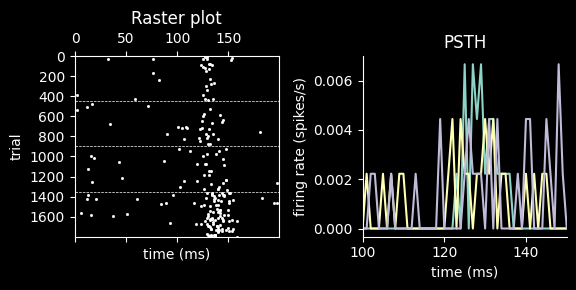

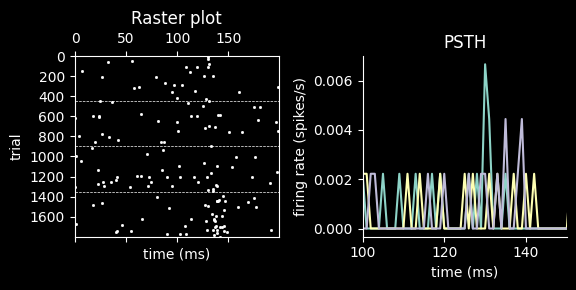

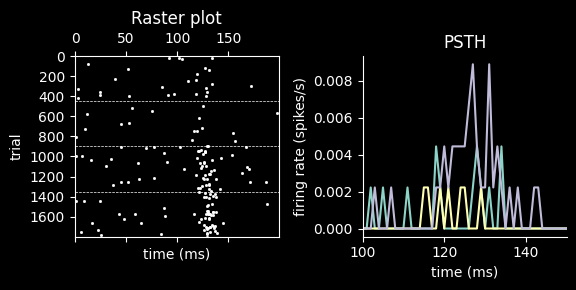

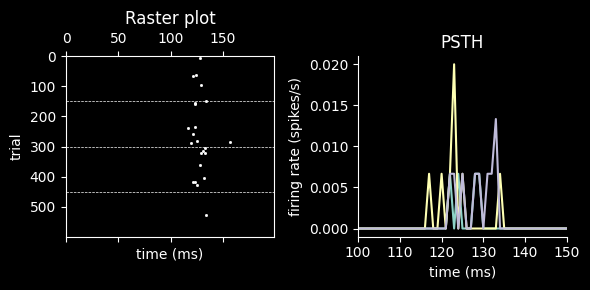

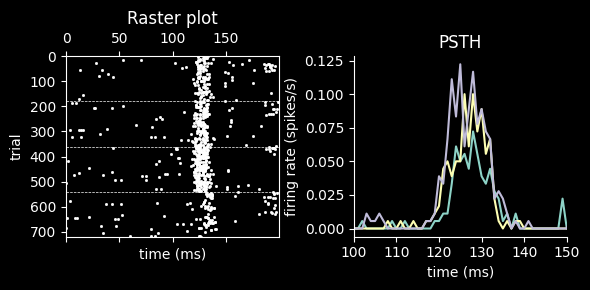

In [ ]:


import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import random
import warnings
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
# pathroot = '/media/nicolascatz/4d767acb-7d35-42a5-b630-86a61f8774d0/nicolascatz/DATA_LINUX_SHARED/Projet_SPIKE_Cluster_GBJNC/Script_pour_figures'
plt.style.use('dark_background')


# here DEFINE THE PATH TO YOUR DATA
pathroot = '/media/nicolascatz/4d767acb-7d35-42a5-b630-86a61f8774d0/nicolascatz/DATA/Projets/EMN_MLP_NC/'
# pathroot = 'D:/DATA/Projet_SPIKE_Cluster_GBJNC/Script_pour_figures/'

pathdata = pathroot + '/data'
pathout= pathroot + '/out'

# open the data
Neuronpop=np.load(pathdata + f'/Neuronpop_0.npz', allow_pickle=True)



for neuron in range(5):

    sua=Neuronpop[f'arr_{neuron}']
    stim=sua[:,0]
    sua=sua[:,1:]
    fig, ax = plt.subplots(1,2,figsize=(6,3))


    ax[0].spy(sua[:,0:200], markersize=1,aspect='auto')
    for cond in range(2,6):
        ax[0].axhline(np.min(np.where(stim==cond)[0]), color='w', ls='--', lw=0.5)
    ax[0].set_title('Raster plot')
    ax[0].set_xlabel('time (ms)')
    ax[0].set_ylabel('trial')
    for cond in range(2,5):
        ax[1].plot(np.mean(sua[stim==cond,:], axis=0) )
    ax[1].set_title('PSTH')
    ax[1].set_xlabel('time (ms)')
    ax[1].set_ylabel('firing rate (spikes/s)')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].set_xlim([100, 150])
    plt.tight_layout()
    plt.show()


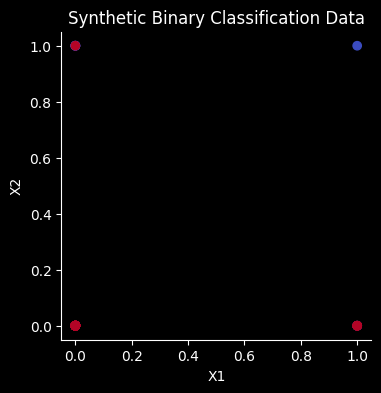

In [2]:


mintrial=100
onset=100
offset=150
Unitpop=[]

for neuron in range(len(Neuronpop)):
    sua=Neuronpop[f'arr_{neuron}'] # get data for one neuron
    Unit2r=random.sample(sua[sua[:,0]==2].tolist(), mintrial) # random sample 100 trials for condition 2
    Unit3r=random.sample(sua[sua[:,0]==3].tolist(), mintrial) # random sample 100 trials for condition 3
    Unit4r=random.sample(sua[sua[:,0]==4].tolist(), mintrial) # random sample 100 trials for condition 4
    Unit5r=random.sample(sua[sua[:,0]==5].tolist(), mintrial) # random sample 100 trials for condition 5

    Unit=np.concatenate((Unit2r,Unit3r,Unit4r,Unit5r), axis=0) # concatenate all trials

    UnitTime=np.sum(Unit[:,onset:offset], axis=1) # sum spikes in the time window
    UnitTime[UnitTime>0]=1 # binarize
    
    Unitpop.append(UnitTime) # add neuron to population matrix

StimTarget=Unit[:,0] # get stimulus labels
StimTarget=np.reshape(StimTarget, (400,1))# reshape to have one column
Unitpop=np.transpose(Unitpop) # transpose to have trials in rows and neurons in columns


X=Unitpop[:200,:]  # take only 200 first trials for the 2 first condition
y=StimTarget[:200]-2 # make labels 0 and 1

y = y.reshape((y.shape[0], 1))


fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("Synthetic Binary Classification Data")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim([-6,9])
# ax.set_ylim([-12,-2])
plt.show()


0.97


(50000, 1)

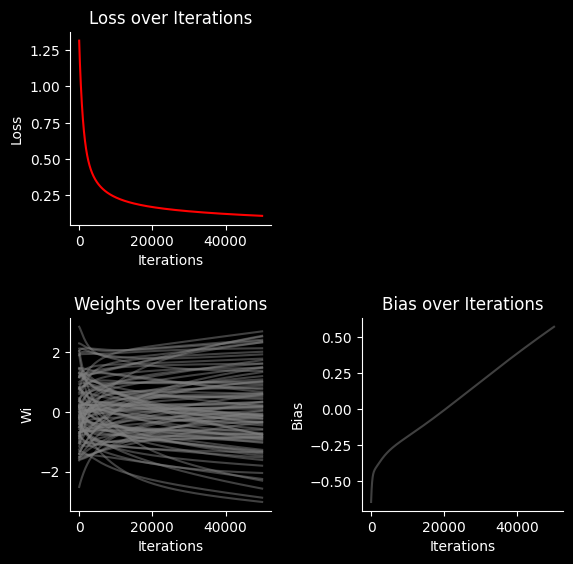

In [3]:
# random definition of W and b for initialisation
# of the first iteration

def initialisation(X):
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return (W, b)
# model and definition of the activation function

def model(X, W, b):
    Z = X.dot(W) + b
    A = 1 / (1 + np.exp(-Z))
    return A


# log loss function

def log_loss(A, y):
    return 1 / len(y) * np.sum(-y * np.log(A) - (1 - y) * np.log(1 - A))

# gradients of the loss function with respect to W and b

def gradients(A, X, y):
    dW = 1 / len(y) * np.dot(X.T, A - y)
    db = 1 / len(y) * np.sum(A - y)
    return (dW, db)

# update of W and b with gradient descent

def update(dW, db, W, b, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return (W, b)

# predict function to classify new data points

def predict(X, W, b):
    A = model(X, W, b)
    # print(A)
    return A >= 0.5

def artificial_neuron(X, y, learning_rate = 0.01, n_iter =50000):
    # initialisation W, b
    W, b = initialisation(X)

    Loss = []
    Wall=[]
    ball=[]
    for i in range(n_iter):
        A = model(X, W, b)
        Loss.append(log_loss(A, y))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
        Wall.append(W)
        ball.append(b)

    y_pred = predict(X, W, b)
    print(accuracy_score(y, y_pred))

    fig, ax = plt.subplots(2,2,figsize=(6,6))
    ax[0,0].plot(Loss, color='red')
    ax[0,0].set_xlabel("Iterations")
    ax[0,0].set_ylabel("Loss")
    ax[0,0].set_title("Loss over Iterations")
    ax[0,0].spines['top'].set_visible(False)
    ax[0,0].spines['right'].set_visible(False)

    ax[1,0].plot(np.array(Wall)[:,:,0],'gray', alpha=0.5)
    ax[1,0].set_xlabel("Iterations")
    ax[1,0].set_ylabel("Wi")
    ax[1,0].set_title("Weights over Iterations")
    ax[1,0].spines['top'].set_visible(False)
    ax[1,0].spines['right'].set_visible(False)

    
    ax[1,1].plot(np.array(ball)[:,0],'gray', alpha=0.5)
    ax[1,1].set_xlabel("Iterations")
    ax[1,1].set_ylabel("Bias")
    ax[1,1].set_title("Bias over Iterations")
    ax[1,1].spines['top'].set_visible(False)
    ax[1,1].spines['right'].set_visible(False)
    ax[0,1].axis('off')  # Hide the empty subplot
    plt.tight_layout(pad=2.0)
    return (W, b, Wall, ball)



W, b, Wall, ball = artificial_neuron(X, y)

np.shape(ball)

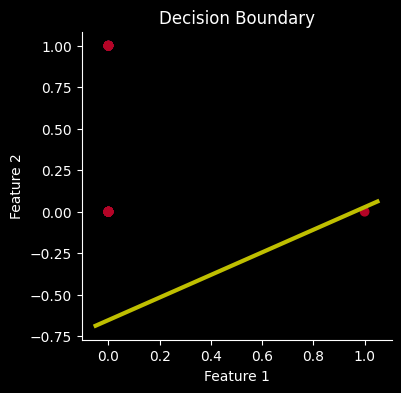

In [4]:
feat1=20
feat2=50

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X[:,feat1], X[:, feat2], c=y, cmap='coolwarm')

xlim=ax.get_xlim()
x1 = np.linspace(xlim[0], xlim[1], 100)
x2 = ( - W[feat1] * x1 - b) / W[feat2]

ax.plot(x1, x2, c='y', lw=3)
ax.set_title("Decision Boundary")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

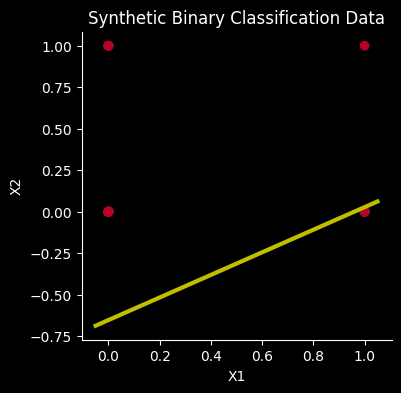

In [5]:

fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
ax.scatter(X[:, 0], X[:, 18], c=y, cmap='coolwarm')
ax.plot(x1, x2, c='y', lw=3)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("Synthetic Binary Classification Data")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim([-6,9])
# ax.set_ylim([-12,-2])
plt.show()

1.4658896318499397
-0.5770728373030991


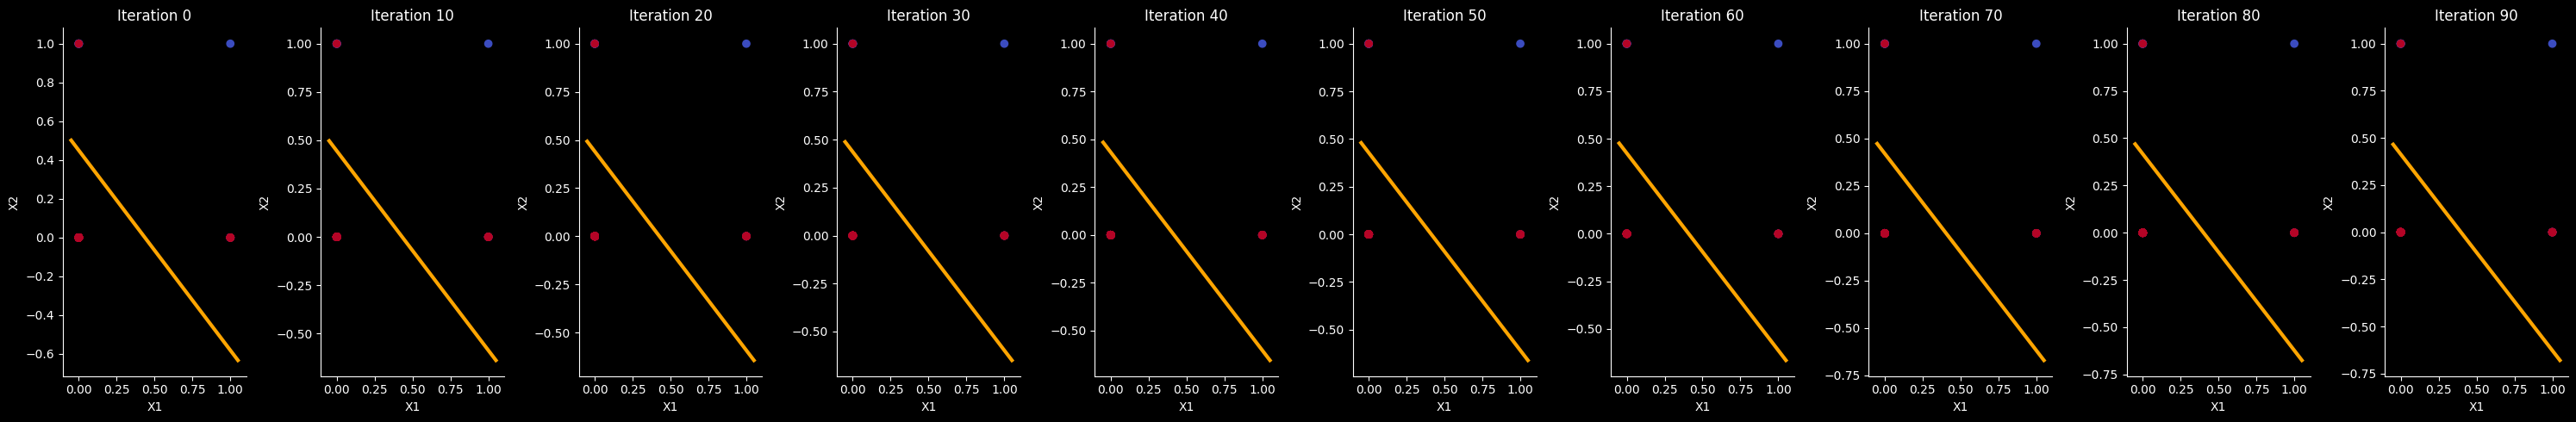

In [6]:
iter=100
print(Wall[iter][0][0])
print(ball[iter][0])

fig, ax = plt.subplots(1, 10, figsize=(30, 5))
for i in range(10):
    iter = i * 10
    ax[i].scatter(X[:,0], X[:, 1], c=y, cmap='coolwarm')
    x1 = np.linspace(xlim[0], xlim[1], 100)
    x2 = ( - Wall[iter][0][0] * x1 - ball[iter][0]) / Wall[iter][1][0]
    ax[i].plot(x1, x2, c='orange', lw=3)
    ax[i].set_title(f"Iteration {iter}")
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)



plt.tight_layout()

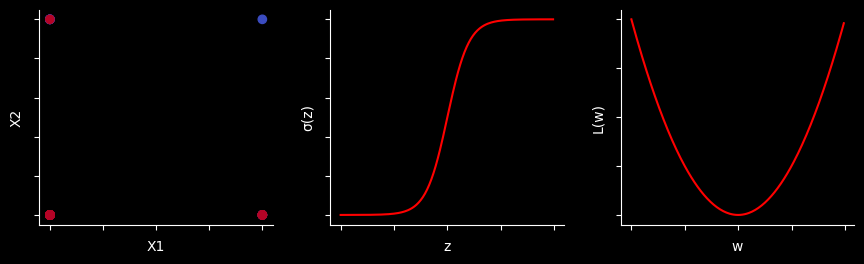

In [7]:

fig, axis = plt.subplots(1,3,figsize=(9,3))
ax=axis[0]
ax.scatter(X[:,0], X[:, 1], c=y, cmap='coolwarm')
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])


x=np.arange(-10,10,0.1)
yy=2*x*x
x1=np.arange(-10,10,0.1)
y1=1/(1+np.exp(-x1))

ax=axis[1]
ax.plot(x1,y1,'r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('z')
ax.set_ylabel('σ(z)')


ax=axis[2]
ax.plot(x,yy,'r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('w')
ax.set_ylabel('L(w)')
plt.tight_layout(pad=2.0)





Accuracy: 0.82


<Axes: >

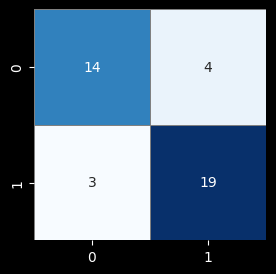

In [8]:
## MLP for N neurons and 2 classes
### using sklearn Perceptron

from sklearn.linear_model import Perceptron

Nneurons=np.shape(Unitpop)[1]

X=Unitpop[0:200,0:Nneurons+1]

y=StimTarget[0:200]-2 # to have labels 0,1,2,3 instead of 2,3,4,5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the Perceptron model
perceptron = Perceptron(random_state=15, max_iter=5000) # increase max_iter if not converged
perceptron.fit(X_train, y_train)

# Make predictions on the test set
y_pred = perceptron.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,linewidths=0.5, linecolor='gray')




In [9]:
## MLP for N neurons and 4 classes

Nneurons=np.shape(Unitpop)[1]

X=Unitpop[:,0:Nneurons]

y=StimTarget-2 # to have labels 0,1,2,3 instead of 2,3,4,5

AccScore_MLP=[]
CM_NN=np.zeros((4,4))
for split in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=split)

    model = Sequential()

    model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100,verbose=0)

    history = model.history.history
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    AccScore_MLP.append(accuracy_score(y_test, y_pred))

    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    accuracy = accuracy * 100
    print(f'Test accuracy: {accuracy:.2f}%')
    print(f'loss: {loss:.4f}')

    cm=confusion_matrix(y_test, y_pred)


E0000 00:00:1763125146.256275 2363668 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763125146.273654 2363668 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7250 - loss: 1.4775  
Test accuracy: 72.50%
loss: 1.4775
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6250 - loss: 1.2404  
Test accuracy: 62.50%
loss: 1.2404
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x753fe4733060> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.

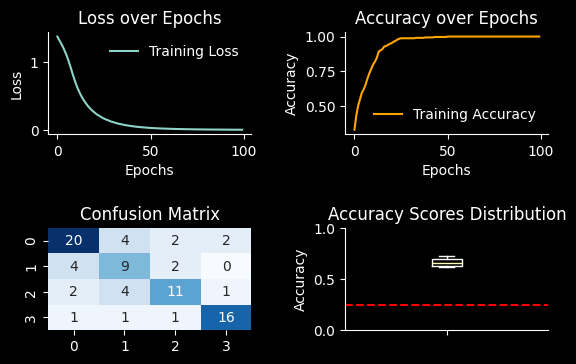

In [10]:

fig, ax = plt.subplots(2, 2, figsize=(6, 4))
ax[0, 0].plot(history['loss'], label='Training Loss')
ax[0, 0].set_title('Loss over Epochs')
ax[0, 0].set_xlabel('Epochs')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend(frameon=False)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 1].plot(history['accuracy'], label='Training Accuracy', color='orange')
ax[0, 1].set_title('Accuracy over Epochs')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Accuracy')
ax[0,1].legend(frameon=False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

sns.heatmap(cm, cmap='Blues', ax=ax[1, 0],cbar=False, annot=True, fmt='d')
ax[1, 0].set_title('Confusion Matrix')

plt.tight_layout(pad=2.0)

ax[1,1].boxplot(AccScore_MLP)
ax[1,1].set_title('Accuracy Scores Distribution')
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].set_ylim([0,1])
ax[1,1].set_ylabel('Accuracy')
ax[1,1].set_xticklabels([])

ax[1,1].axhline(0.25, color='r', ls='--', label='Threshold Accuracy')
plt.tight_layout(pad=2.0)
